In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import tensorflow as tf
print(sys.version)
%matplotlib inline

3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]


In [5]:
print(tf.__version__)

2.3.1


In [4]:
# ! pip install --upgrade tensorflow-gpu

In [6]:
ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

In [7]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

In [8]:
train_image_folder = "/media/vkr/VKR/WorkSpace/Deep Learning Projects/yolov2/data/processed/VOC2012/JPEGImages/"
train_annot_folder = "/media/vkr/VKR/WorkSpace/Deep Learning Projects/yolov2/data/processed/VOC2012/Annotations/"

np.random.seed(1)
from backend import parse_annotation
train_image, seen_train_labels = parse_annotation(train_annot_folder,
                                                  train_image_folder, 
                                                  labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 22263


In [16]:
from backend import SimpleBatchGenerator

BATCH_SIZE        = 2
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)
# CLASS             = len(LABELS)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


def normalize(image):
    return image / 255.
train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)


In [17]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

In [18]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX): 
    '''
    Helper function to assure that the bounding box x and y are in the grid cell scale
    == output == 
    for any i=0,1..,batch size - 1
    output[i,5,3,:,:] = array([[3., 5.],
                               [3., 5.],
                               [3., 5.]], dtype=float32)
    '''
    ## cell_x.shape = (1, 13, 13, 1, 1)
    ## cell_x[:,i,j,:] = [[[j]]]
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    # tf.cast(num, tf.float32)
    ## cell_y.shape = (1, 13, 13, 1, 1)
    ## cell_y[:,i,j,:] = [[[i]]]
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    ## cell_gird.shape = (16, 13, 13, 5, 2)
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = j when k = 0
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = i when k = 1    
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return(cell_grid) 

def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):    
    """
        Adjust prediction
        
        == input ==
        
        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
        
        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==
        
        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1
          
          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                                   takes values between 0 and grid_H - 1 for y coordinate 
                                                   
        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]
        
        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
        
        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing 
    """
    BOX = int(len(ANCHORS)/2)
    ## cell_grid is of the shape of 
    
    ### adjust x and y  
    # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
    # Since there are BOX x BOX grids, we rescale each bx and by to range between 0 to BOX + 1
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by
    
    ### adjust w and h
    # exp to make width and height positive
    # rescale each grid to make some anchor "good" at representing certain shape of bounding box 
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) # bw, bh

    ### adjust confidence 
    pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb

    ### adjust class probabilities 
    pred_box_class = y_pred[..., 5:] # prC1, prC2, ..., prC20
    
    return(pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class)


In [19]:
def print_min_max(vec,title):
    try:
        print("{} MIN={:5.2f}, MAX={:5.2f}".format(
            title, np.min(vec),np.max(vec)))
    except ValueError:  #raised if `y` is empty.
        pass

print("*"*30)
print("prepare inputs")
GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS)/2)
CLASS = len(LABELS)
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4 + 1 + CLASS)
print("y_pred before scaling = {}".format(y_pred.shape))

print("*"*30)
print("define tensor graph")
y_pred_tf = tf.constant(y_pred,dtype="float32")
cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)

(pred_box_xy,   pred_box_wh, 
 pred_box_conf, pred_box_class) = adjust_scale_prediction(y_pred_tf, 
                                                                cell_grid, 
                                                                ANCHORS)
print("*"*30 + "\nouput\n" + "*"*30) 
# with tf.Session() as sess:
#     (pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class) = sess.run([pred_box_xy_tf,   pred_box_wh_tf, pred_box_conf_tf, pred_box_class_tf])
    
print("\npred_box_xy {}".format(pred_box_xy.shape))           

for igrid_w in range(pred_box_xy.shape[2]):
        print_min_max(pred_box_xy[:,:,igrid_w,:,0],
                      "  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:,igrid_h,:,:,1],
                  "  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(pred_box_wh[:,:,:,:,1],"  bounding box height") 
    
print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf,"  confidence ") 

print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class,"  class probability") 


******************************
prepare inputs
y_pred before scaling = (2, 13, 13, 4, 25)
******************************
define tensor graph
******************************
ouput
******************************

pred_box_xy (2, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.47, MAX= 0.53
  bounding box x at iGRID_W=01 MIN= 1.47, MAX= 1.53
  bounding box x at iGRID_W=02 MIN= 2.46, MAX= 2.53
  bounding box x at iGRID_W=03 MIN= 3.45, MAX= 3.53
  bounding box x at iGRID_W=04 MIN= 4.47, MAX= 4.54
  bounding box x at iGRID_W=05 MIN= 5.47, MAX= 5.53
  bounding box x at iGRID_W=06 MIN= 6.46, MAX= 6.53
  bounding box x at iGRID_W=07 MIN= 7.47, MAX= 7.55
  bounding box x at iGRID_W=08 MIN= 8.47, MAX= 8.53
  bounding box x at iGRID_W=09 MIN= 9.46, MAX= 9.53
  bounding box x at iGRID_W=10 MIN=10.46, MAX=10.53
  bounding box x at iGRID_W=11 MIN=11.46, MAX=11.54
  bounding box x at iGRID_W=12 MIN=12.46, MAX=12.54
  bounding box y at iGRID_H=00 MIN= 0.47, MAX= 0.53
  bounding box y at iGRID_H=01 MI

## Step 2: Extract ground truth output

In [20]:
def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4]    # confidence 
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)

In [21]:
# y_batch is the output of the simpleBatchGenerator.fit()
print("Input y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy, true_box_wh, 
 true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

# with tf.Session() as sess:
#         (true_box_xy, true_box_wh, 
#          true_box_conf, true_box_class) = sess.run(
#                     [true_box_xy_tf,   true_box_wh_tf, 
#                      true_box_conf_tf, true_box_class_tf])

print("\ntrue_box_xy {}".format(true_box_xy.shape))        
for igrid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:,:,igrid_w,:,0]
    pick = true_box_conf[:,:,igrid_w,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
    
for igrid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:,igrid_h,:,:,1]
    pick = true_box_conf[:,igrid_h,:,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\ntrue_box_wh {}".format(true_box_wh.shape))
print_min_max(true_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(true_box_wh[:,:,:,:,1],"  bounding box height") 
    
print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("  confidence, unique value = {}".format(np.unique(true_box_conf))) 

print("\ntrue_box_class {}".format(true_box_class.shape))
print("  class index, unique value = {}".format(np.unique(true_box_class)) )


Input y_batch = (2, 13, 13, 4, 25)
******************************
ouput
******************************

true_box_xy (2, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.36, MAX= 0.36
  bounding box x at iGRID_W=04 MIN= 4.14, MAX= 4.22
  bounding box x at iGRID_W=05 MIN= 5.20, MAX= 5.81
  bounding box x at iGRID_W=06 MIN= 6.89, MAX= 6.89
  bounding box x at iGRID_W=07 MIN= 7.16, MAX= 7.48
  bounding box x at iGRID_W=09 MIN= 9.84, MAX= 9.84
  bounding box x at iGRID_W=11 MIN=11.50, MAX=11.50
  bounding box y at iGRID_H=05 MIN= 5.34, MAX= 5.36
  bounding box y at iGRID_H=06 MIN= 6.05, MAX= 6.05
  bounding box y at iGRID_H=07 MIN= 7.02, MAX= 7.41
  bounding box y at iGRID_H=08 MIN= 8.70, MAX= 8.70
  bounding box y at iGRID_H=10 MIN=10.05, MAX=10.05
  bounding box y at iGRID_H=11 MIN=11.31, MAX=11.31
  bounding box y at iGRID_H=12 MIN=12.20, MAX=12.20

true_box_wh (2, 13, 13, 4, 2)
  bounding box width  MIN= 0.00, MAX=10.41
  bounding box height MIN= 0.00, MAX=11.47

true_box_conf (2, 13

## Step 3: calculate lossxywhi,j

In [29]:
def calc_loss_xywh(true_box_conf,
                   COORD_SCALE,
                   true_box_xy, pred_box_xy,true_box_wh,pred_box_wh):  
    '''
    coord_mask:      np.array of shape (Nbatch, Ngrid h, N grid w, N anchor, 1)
                     lambda_{coord} L_{i,j}^{obj}     
                         
    '''
    
    # lambda_{coord} L_{i,j}^{obj} 
    # np.array of shape (Nbatch, Ngrid h, N grid w, N anchor, 1)
    coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * COORD_SCALE 
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))
    
    loss_xy      = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh      = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    return(loss_xy + loss_wh, coord_mask)

In [30]:
# Experiment calc_loss_xywh

LAMBDA_COORD = 1
loss_xywh, coord_mask  = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                               true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)

print("*"*30 + "\nouput\n" + "*"*30) 

# with tf.Session() as sess:
#         loss_xywh = sess.run([loss_xywh_tf])[0]
print("loss_xywh = {:4.3f}".format(loss_xywh))


******************************
ouput
******************************
loss_xywh = 2.542


## Step 4: calculate losspi,j

In [32]:
def calc_loss_class(true_box_conf,CLASS_SCALE, true_box_class,pred_box_class):
    '''
    == input ==    
    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
    true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
    pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
    CLASS_SCALE    : 1.0
    
    == output ==  
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else: 
        0 
    '''   
    class_mask   = true_box_conf  * CLASS_SCALE ## L_{i,j}^obj * lambda_class
    
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, 
                                                                  logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)   
    return loss_class

In [33]:
LAMBDA_CLASS   = 1
loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                 true_box_class,pred_box_class)
print("*"*30 + "\nouput\n" + "*"*30) 
print("loss_class = {:4.3f}".format(loss_class))

******************************
ouput
******************************
loss_class = 2.997


## Step 5, calculate IOUground truthi,j ; preduictioni,j

In [34]:
def get_intersect_area(true_xy,true_wh,
                       pred_xy,pred_wh):
    '''
    == INPUT ==
    true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                 p1______________________ 
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2 
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)
        
    '''
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)    
    return iou_scores

def calc_IOU_pred_true_assigned(true_box_conf,
                                true_box_xy, true_box_wh,
                                pred_box_xy,  pred_box_wh):
    ''' 
    == input ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
        
    == output ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)
    
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    '''
    iou_scores        =  get_intersect_area(true_box_xy,true_box_wh,
                                            pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return true_box_conf_IOU

true_box_conf_IOU.shape = (2, 13, 13, 4)


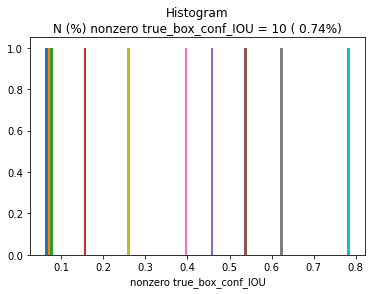

In [37]:
# Experiment calc_IOU_pred_true_assigned

true_box_conf_IOU = calc_IOU_pred_true_assigned(
                            true_box_conf,
                            true_box_xy, true_box_wh,
                            pred_box_xy,  pred_box_wh)

# print("*"*30 + "\ninput\n" + "*"*30)    
# print("true_box_conf = {}".format(true_box_conf))
# print("true_box_xy   = {}".format(true_box_xy))
# print("true_box_wh   = {}".format(true_box_wh))
# print("pred_box_xy   = {}".format(pred_box_xy))
# print("pred_box_wh   = {}".format(pred_box_wh))
# print("*"*30 + "\nouput\n" + "*"*30) 
print("true_box_conf_IOU.shape = {}".format(true_box_conf_IOU.shape))
vec  = true_box_conf_IOU
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero true_box_conf_IOU")
plt.show()

## Step 6: Calculate $\text{max}_{i',j'}

In [39]:
def calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):   
    '''
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    
    == output == 
    
    best_ious
    
    for each iframe,
        best_ious[iframe,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = true_boxes[..., 0:2]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = true_boxes[..., 2:4]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    
    iou_scores  =  get_intersect_area(true_xy,
                                      true_wh,
                                      pred_xy,
                                      pred_wh) # (N batch, N grid_h, N grid_w, N anchor, 50)   

    best_ious = tf.reduce_max(iou_scores, axis=4) # (N batch, N grid_h, N grid_w, N anchor)
    return best_ious

best_ious.shape = (2, 13, 13, 4)


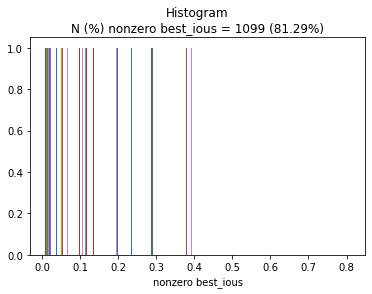

In [41]:
# Experiment calc_IOU_pred_true_best

true_boxes = tf.constant(b_batch,dtype="float32")
best_ious = calc_IOU_pred_true_best(pred_box_xy,
                                       pred_box_wh,
                                       true_boxes)
    
# print("*"*30 + "\ninput\n" + "*"*30)    
# print("true_box_wh   = {}".format(true_box_wh))
# print("pred_box_xy   = {}".format(pred_box_xy))
# print("pred_box_wh   = {}".format(pred_box_wh))
# print("*"*30 + "\nouput\n" + "*"*30) 
print("best_ious.shape = {}".format(best_ious.shape))
vec  = best_ious
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero best_ious = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero best_ious")
plt.show()

In [42]:
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT):    
    '''
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair        
    '''

    conf_mask = tf.cast(best_ious < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return conf_mask

In [44]:
# Experiment get_conf_mask

conf_mask = get_conf_mask(best_ious, 
                             true_box_conf, 
                             true_box_conf_IOU,
                             LAMBDA_NO_OBJECT, 
                             LAMBDA_OBJECT)
# print("*"*30 + "\ninput\n" + "*"*30)  
# print("best_ious         = {}".format(best_ious)) 
# print("true_box_conf     = {}".format(true_box_conf))
# print("true_box_conf_IOU = {}".format(true_box_conf_IOU))
# print("LAMBDA_NO_OBJECT  = {}".format(LAMBDA_NO_OBJECT)) 
# print("LAMBDA_OBJECT     = {}".format(LAMBDA_OBJECT))

print("*"*30 + "\noutput\n" + "*"*30)      
print("conf_mask shape = {}".format(conf_mask.shape))

******************************
output
******************************
conf_mask shape = (2, 13, 13, 4)


## Step 8: Calculate loss for the confidence lossci,j

In [45]:
def calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf):  
    '''
    == input ==
    
    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    '''
    # the number of (grid cell, anchor) pair that has an assigned object or
    # that has no assigned object but some objects may be in bounding box.
    # N conf
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    return loss_conf

In [47]:
# Experiment calc_loss_conf

# print("*"*30 + "\ninput\n" + "*"*30)  
# print("conf_mask         = {}".format(conf_mask)) 
# print("true_box_conf_IOU = {}".format(true_box_conf_IOU))
# print("pred_box_conf     = {}".format(pred_box_conf))

loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)
    
print("*"*30 + "\noutput\n" + "*"*30)      
print("loss_conf = {:5.4f}".format(loss_conf))

******************************
output
******************************
loss_conf = 0.1246


## custom_loss(y_true,y_pred)

In [48]:
def custom_loss(y_true, y_pred):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    
        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
                   
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
        
        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair
    
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category  else 0
        
    '''
    total_recall = tf.Variable(0.)
    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    # Step 5: For each (grid cell, anchor) pair, 
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)

    
    loss = loss_xywh + loss_conf + loss_class
    

    
    return loss

In [49]:
# Experiment custom_loss

print(y_batch.dtype, y_pred.dtype)
true_boxes = tf.Variable(np.zeros_like(b_batch), dtype="float32")
loss = custom_loss(y_batch.astype('float32'), y_pred.astype('float32')) 
print('loss', loss)

float64 float64
loss tf.Tensor(5.663559, shape=(), dtype=float32)
